### Target:

* To Add LR Scheduler
* To acheive 99.4% accuracy

### Results:

* Parameters: 9.1k
* Best Train Accuracy: 99.02
* Best Test Accuracy: 99.36

### Analysis:
* The model has less than 10k parameters
* Increasing the capacity has helped the model to learn model


# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                    #    transforms.ToPILImage(),
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(2.8066)
 - std: tensor(0.2168)
 - var: tensor(0.0470)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


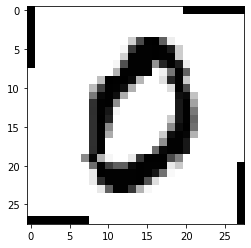

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

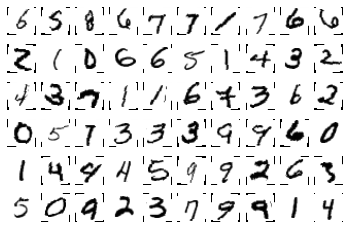

In [6]:




figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')


# The model
Let's start with the model we first saw

In [7]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout2d(0.01)
        ) # output_size = 26*26*5

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.Dropout2d(0.01)
        ) # output_size = 24*24*10
        
        # Transition block
        self.maxPool = nn.MaxPool2d(2,2)#output=12*12*10

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=20, kernel_size=3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout2d(0.01)
        )#output= 10*10*15

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=15, kernel_size=3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.Dropout2d(0.01)
        )#output = 8*8*20

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.Dropout2d(0.01)
        )#output = 6*6*20
        # self.maxPool2 = nn.MaxPool2d(2,2)#output=3*3*20

        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=20, out_channels=10, kernel_size=1, padding=0, bias=False)
        #Output Block
        self.gap = nn.AvgPool2d(6)#output=1*1*20

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=1, padding=0, bias=False)
        )#1*1*10


    def forward(self, x):
        
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.maxPool(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        # x = self.MaxPool2(x)
        # x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock6(x)
      
        x = x.reshape(-1,10)

        return F.log_softmax(x, dim=-1)


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 15, 24, 24]           1,350
              ReLU-6           [-1, 15, 24, 24]               0
       BatchNorm2d-7           [-1, 15, 24, 24]              30
         Dropout2d-8           [-1, 15, 24, 24]               0
         MaxPool2d-9           [-1, 15, 12, 12]               0
           Conv2d-10           [-1, 20, 10, 10]           2,700
             ReLU-11           [-1, 20, 10, 10]               0
      BatchNorm2d-12           [-1, 20, 10, 10]              40
        Dropout2d-13           [-1, 20, 10, 10]               0
           Conv2d-14             [

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR

# will be used while plotting graphs

training_losses = []
testing_losses = []
training_accuracy = []
testing_accuracy = []


model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(1, 16):
    print("EPOCH:", epoch, "LR = ", scheduler.get_lr())
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


EPOCH: 1 LR =  [0.01]


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.0884041115641594 Batch_id=468 Accuracy=86.49: 100%|██████████| 469/469 [00:42<00:00, 11.09it/s]



Test set: Average loss: 0.0829, Accuracy: 9785/10000 (97.85%)

EPOCH: 2 LR =  [0.01]


Loss=0.07314392179250717 Batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:42<00:00, 10.99it/s]



Test set: Average loss: 0.0489, Accuracy: 9868/10000 (98.68%)

EPOCH: 3 LR =  [0.01]


Loss=0.1422182321548462 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:42<00:00, 10.95it/s]



Test set: Average loss: 0.0403, Accuracy: 9887/10000 (98.87%)

EPOCH: 4 LR =  [0.01]


Loss=0.046082157641649246 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:43<00:00, 10.89it/s]



Test set: Average loss: 0.0308, Accuracy: 9918/10000 (99.18%)

EPOCH: 5 LR =  [0.01]


Loss=0.037834037095308304 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:43<00:00, 10.89it/s]



Test set: Average loss: 0.0309, Accuracy: 9910/10000 (99.10%)

EPOCH: 6 LR =  [0.01]


Loss=0.04442779719829559 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:43<00:00, 10.89it/s]



Test set: Average loss: 0.0265, Accuracy: 9921/10000 (99.21%)

EPOCH: 7 LR =  [0.0001]


Loss=0.02320636808872223 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:43<00:00, 10.89it/s]



Test set: Average loss: 0.0230, Accuracy: 9927/10000 (99.27%)

EPOCH: 8 LR =  [0.001]


Loss=0.02505207061767578 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:43<00:00, 10.82it/s]



Test set: Average loss: 0.0217, Accuracy: 9930/10000 (99.30%)

EPOCH: 9 LR =  [0.001]


Loss=0.05955049395561218 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:43<00:00, 10.74it/s]



Test set: Average loss: 0.0217, Accuracy: 9931/10000 (99.31%)

EPOCH: 10 LR =  [0.001]


Loss=0.006949784699827433 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:43<00:00, 10.70it/s]



Test set: Average loss: 0.0209, Accuracy: 9935/10000 (99.35%)

EPOCH: 11 LR =  [0.001]


Loss=0.011027884669601917 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:43<00:00, 10.83it/s]



Test set: Average loss: 0.0210, Accuracy: 9937/10000 (99.37%)

EPOCH: 12 LR =  [0.001]


Loss=0.02114737033843994 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:43<00:00, 10.77it/s]



Test set: Average loss: 0.0209, Accuracy: 9936/10000 (99.36%)

EPOCH: 13 LR =  [1e-05]


Loss=0.07293014973402023 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:43<00:00, 10.79it/s]



Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

EPOCH: 14 LR =  [0.0001]


Loss=0.04374388977885246 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:43<00:00, 10.85it/s]



Test set: Average loss: 0.0210, Accuracy: 9935/10000 (99.35%)

EPOCH: 15 LR =  [0.0001]


Loss=0.018224431201815605 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:43<00:00, 10.78it/s]



Test set: Average loss: 0.0203, Accuracy: 9933/10000 (99.33%)



# Let's Train and test our model

In [13]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR

# will be used while plotting graphs

training_losses = []
testing_losses = []
training_accuracy = []
testing_accuracy = []


model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.001)

for epoch in range(1, 20):
    print("EPOCH:", epoch, "LR = ", scheduler.get_lr())
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


EPOCH: 1 LR =  [0.01]


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.12711672484874725 Batch_id=468 Accuracy=87.51: 100%|██████████| 469/469 [00:42<00:00, 10.93it/s]



Test set: Average loss: 0.0832, Accuracy: 9781/10000 (97.81%)

EPOCH: 2 LR =  [0.01]


Loss=0.03139360621571541 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:43<00:00, 10.84it/s]



Test set: Average loss: 0.0461, Accuracy: 9861/10000 (98.61%)

EPOCH: 3 LR =  [0.01]


Loss=0.05045418068766594 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:43<00:00, 10.73it/s]



Test set: Average loss: 0.0372, Accuracy: 9892/10000 (98.92%)

EPOCH: 4 LR =  [0.01]


Loss=0.10102319717407227 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:44<00:00, 10.65it/s]



Test set: Average loss: 0.0303, Accuracy: 9902/10000 (99.02%)

EPOCH: 5 LR =  [0.01]


Loss=0.13172367215156555 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:43<00:00, 10.78it/s]



Test set: Average loss: 0.0282, Accuracy: 9904/10000 (99.04%)

EPOCH: 6 LR =  [0.01]


Loss=0.03614721819758415 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:44<00:00, 10.57it/s]



Test set: Average loss: 0.0244, Accuracy: 9921/10000 (99.21%)

EPOCH: 7 LR =  [1e-08]


Loss=0.016543211415410042 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:43<00:00, 10.68it/s]



Test set: Average loss: 0.0245, Accuracy: 9914/10000 (99.14%)

EPOCH: 8 LR =  [1e-05]


Loss=0.013369726948440075 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:43<00:00, 10.74it/s]



Test set: Average loss: 0.0242, Accuracy: 9917/10000 (99.17%)

EPOCH: 9 LR =  [1e-05]


Loss=0.07373253256082535 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:44<00:00, 10.59it/s]



Test set: Average loss: 0.0242, Accuracy: 9916/10000 (99.16%)

EPOCH: 10 LR =  [1e-05]


Loss=0.07757475227117538 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:44<00:00, 10.52it/s]



Test set: Average loss: 0.0245, Accuracy: 9917/10000 (99.17%)

EPOCH: 11 LR =  [1e-05]


Loss=0.024485647678375244 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:43<00:00, 10.66it/s]



Test set: Average loss: 0.0236, Accuracy: 9920/10000 (99.20%)

EPOCH: 12 LR =  [1e-05]


Loss=0.03447020798921585 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:44<00:00, 10.54it/s]



Test set: Average loss: 0.0238, Accuracy: 9922/10000 (99.22%)

EPOCH: 13 LR =  [1.0000000000000001e-11]


Loss=0.015519637614488602 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:44<00:00, 10.53it/s]



Test set: Average loss: 0.0240, Accuracy: 9919/10000 (99.19%)

EPOCH: 14 LR =  [1e-08]


Loss=0.04077558591961861 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:44<00:00, 10.48it/s]



Test set: Average loss: 0.0238, Accuracy: 9921/10000 (99.21%)

EPOCH: 15 LR =  [1e-08]


Loss=0.0338553823530674 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:44<00:00, 10.60it/s]



Test set: Average loss: 0.0239, Accuracy: 9920/10000 (99.20%)

EPOCH: 16 LR =  [1e-08]


Loss=0.021470682695508003 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:44<00:00, 10.59it/s]



Test set: Average loss: 0.0240, Accuracy: 9919/10000 (99.19%)

EPOCH: 17 LR =  [1e-08]


Loss=0.020360158756375313 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:43<00:00, 10.69it/s]



Test set: Average loss: 0.0239, Accuracy: 9918/10000 (99.18%)

EPOCH: 18 LR =  [1e-08]


Loss=0.0111122727394104 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:44<00:00, 10.58it/s]



Test set: Average loss: 0.0241, Accuracy: 9919/10000 (99.19%)

EPOCH: 19 LR =  [1.0000000000000002e-14]


Loss=0.07782577723264694 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:44<00:00, 10.63it/s]



Test set: Average loss: 0.0240, Accuracy: 9918/10000 (99.18%)



Text(0.5, 1.0, 'Test Accuracy')

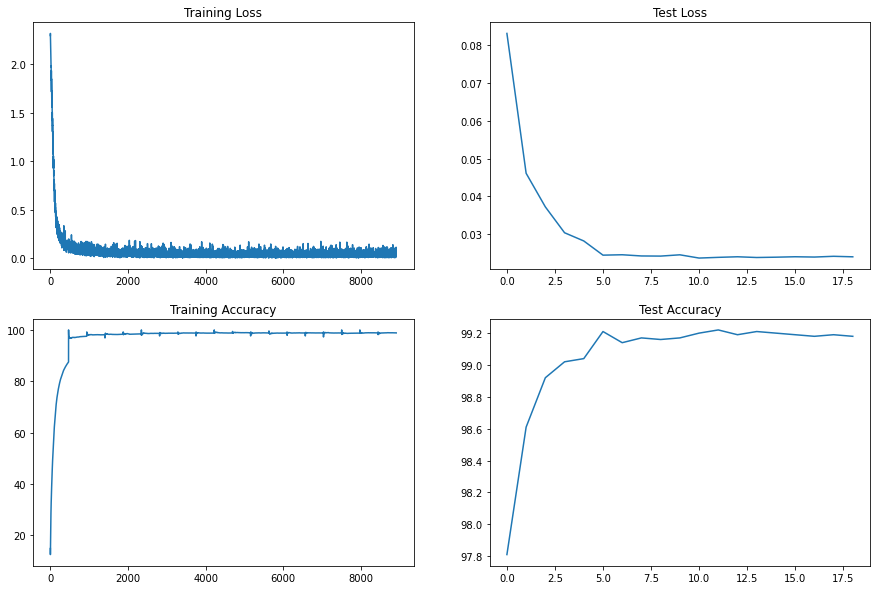

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [15]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR

# will be used while plotting graphs

training_losses = []
testing_losses = []
training_accuracy = []
testing_accuracy = []


optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.0001)

for epoch in range(15):
    print("EPOCH:", epoch, "LR = ", scheduler.get_lr())
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


EPOCH: 0 LR =  [0.01]


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.02558945119380951 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:43<00:00, 10.71it/s]



Test set: Average loss: 0.0271, Accuracy: 9915/10000 (99.15%)

EPOCH: 1 LR =  [0.01]


Loss=0.006500560324639082 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:43<00:00, 10.81it/s]



Test set: Average loss: 0.0238, Accuracy: 9923/10000 (99.23%)

EPOCH: 2 LR =  [0.01]


Loss=0.028943093493580818 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:43<00:00, 10.67it/s]



Test set: Average loss: 0.0219, Accuracy: 9932/10000 (99.32%)

EPOCH: 3 LR =  [0.01]


Loss=0.017581263557076454 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:43<00:00, 10.80it/s]



Test set: Average loss: 0.0230, Accuracy: 9934/10000 (99.34%)

EPOCH: 4 LR =  [0.01]


Loss=0.00943188089877367 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:43<00:00, 10.76it/s]



Test set: Average loss: 0.0223, Accuracy: 9934/10000 (99.34%)

EPOCH: 5 LR =  [0.01]


Loss=0.006166777107864618 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:43<00:00, 10.76it/s]



Test set: Average loss: 0.0208, Accuracy: 9927/10000 (99.27%)

EPOCH: 6 LR =  [1.0000000000000002e-10]


Loss=0.007684428244829178 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:43<00:00, 10.81it/s]



Test set: Average loss: 0.0209, Accuracy: 9932/10000 (99.32%)

EPOCH: 7 LR =  [1.0000000000000002e-06]


Loss=0.028586408123373985 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:44<00:00, 10.65it/s]



Test set: Average loss: 0.0211, Accuracy: 9928/10000 (99.28%)

EPOCH: 8 LR =  [1.0000000000000002e-06]


Loss=0.015331367962062359 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:43<00:00, 10.68it/s]



Test set: Average loss: 0.0205, Accuracy: 9930/10000 (99.30%)

EPOCH: 9 LR =  [1.0000000000000002e-06]


Loss=0.021563850343227386 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:44<00:00, 10.61it/s]



Test set: Average loss: 0.0208, Accuracy: 9930/10000 (99.30%)

EPOCH: 10 LR =  [1.0000000000000002e-06]


Loss=0.017102008685469627 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:44<00:00, 10.53it/s]



Test set: Average loss: 0.0206, Accuracy: 9931/10000 (99.31%)

EPOCH: 11 LR =  [1.0000000000000002e-06]


Loss=0.00370203610509634 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:44<00:00, 10.60it/s]



Test set: Average loss: 0.0207, Accuracy: 9926/10000 (99.26%)

EPOCH: 12 LR =  [1.0000000000000002e-14]


Loss=0.02853233925998211 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:44<00:00, 10.56it/s]



Test set: Average loss: 0.0207, Accuracy: 9929/10000 (99.29%)

EPOCH: 13 LR =  [1.0000000000000002e-10]


Loss=0.024017339572310448 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:44<00:00, 10.55it/s]



Test set: Average loss: 0.0207, Accuracy: 9926/10000 (99.26%)

EPOCH: 14 LR =  [1.0000000000000002e-10]


Loss=0.05131848528981209 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:44<00:00, 10.55it/s]



Test set: Average loss: 0.0211, Accuracy: 9927/10000 (99.27%)

